# Graph Neural Networks for Stock Portfolio Optimization (April'23)

The task of optimizing the investment portfolio is one of the most multifaceted in the field of financial management. The application of neural networks to this task has long attracted researchers from all over the world. To date, several approaches have been established. One of the most popular "predict - then - optimize".


## Stocks universe
The objective of this notebook is to try construct the pipeline for portfolio optimization based on 10 most liquid ETF. ETF Universe include 

Stocks:
- **SPY** (SPDR S&P 500 ETF Trust)
- **VIT** (Vanguard Value ETF)
- **VUG** (Vanguard Growth ETF)
- **VWO** (Vanguard FTSE Emerging Markets ETF)
- **VYM** (Vanguard High Dividend Yield ETF)
- **QQQ** (Invesco QQQ Trust)
- **VEA** (Vanguard FTSE Developed Markets ETF)

Bonds:
- **BND** (Vanguard Total Bond Market ETF)

Real Estate:
- **VNG** (Vanguard Real Estate ETF)

Commodities:
- **GLD** (SPDR Gold Trust)

Different asset classes were chosen to increase diversification and robustness of a portfolio. The Data was downloader from Yahoo Finance from an ETF inception till February 27, 2023.

## Features

For the first phase of the work, I selected features based on the Technical Analysis. Following indicators were included in the pipeline:

Trend:

- [MACD](https://school.stockcharts.com/doku.php?id=technical_indicators:moving_average_convergence_divergence_macd)
- [Vortex Indicator](https://school.stockcharts.com/doku.php?id=technical_indicators:vortex_indicator)

Momentum:

- [RSI](https://school.stockcharts.com/doku.php?id=technical_indicators:relative_strength_index_rsi) 
- [Stochastic Oscillator](https://school.stockcharts.com/doku.php?id=technical_indicators:stochastic_oscillator_fast_slow_and_full) 
- [Williams RIndicator](https://school.stockcharts.com/doku.php?id=technical_indicators:williams_r)

Volatility:

- [Ulcer Index](https://school.stockcharts.com/doku.php?id=technical_indicators:ulcer_index)

All of them provide signals on relative scale, which helps to abstact from absolute price and volume changes. The alternative to using technical indicators cann be embeddings obtained from LSTM or from GPT networks. These possibilities will be studied in the future.

## Graph Neural Networks

Graph neural netowrks are particularly suitable for problems involving the interconnections of objects. In the case of portfolio optimization, it is clearly the case, because asset performance is correlated and interdependent for multiple reasons: economical, political, technical etc. 

### Graph Attention Networks

Firstly, proposed in the paper [Graph Attention Networks](https://arxiv.org/abs/1710.10903), Grapth Attention Networks include the same wide-known concept of attention, that was previously established in NLP. In GAT attention is calclulated based on learnable matrix $W$ and vector a $a$. In the problems with  binary adjacency matrix, adjacency matrix serve the functgion of $mask$ for attention mechanism, however, when adjacency matrix is not binary (correlation matrix), final result is obtained by multiplying attention score on adjacency matrix to get the embedding of the node. 

<img src="img/GAT_1.png" alt="GAT 1" style="width: 1000px;"/>



## Optimization Approaches

Most studies focuses on the integration approaches that help to unite prediction and optimization tasks in the single one. For example in a paper ["Distributionally Robust End-to-End Portfolio Construction"](https://arxiv.org/abs/2206.05134) authors divide the whole pipeline into 2 stages:

- prediction layer (predict future returns)
- decision layer (optize portfolio and compute loss on weighted average of MSE and observed Sharpe Ratio)

The pipeline for this approach

<img src="img/1.png" alt="Schema 1" style="width: 1000px;"/>

In another paper ["End-to-End Risk Budgeting Portfolio Optimization with Neural Networks"](https://arxiv.org/abs/2107.04636) authors try to use a Risk-Budgeting Approach. It also consists of two stages:

- prediction layer (predict risk-contributions/risk-budgets)
- Optimization layer (optimize weights based on risk budgeting)

The pipeline for this approach:

<img src="img/3.png" alt="Schema 2" style="width: 1000px;"/>

Therefore, I decided to implement similar yet maybe simplier pipelines in this notebook:

- **1st approach**
    - prediction layer (predict 14-days returns)
    - optimization layer (calculate weights based on predicted return to achive maximum Sharpe)

- **2nd approach**
    - prediction layer (predict risk contributions/risk-budgets)
    - optimization layer (calculate optimal weights on predicted risk-weights)

In the first approach I optimized only the predcition layer, while in the second appraoch I optimized maximum return (strictly speaking, minimized -return).

## Pipeline

Overall, pipeline includes following stages:

1. Generate features based on technical indicators.

2. Calculate covariance and correlation matrices. Use correlation matrix as an adjacency matrix.

3. Build two models with different number of layers.

4. Train them and calculate overall perfomance, compared it with equal-weight portfolio (as a benchmark)



## Navigation Table
* [EDA](#eda)
    * [Stocks Performance](#eda_performance)
    * [Stocks Correlation](#eda_correlation)
* [Data Preparation](#embeddings)
* [Neural Networks](#nn)
    * [Optimization Layer (Sharpe)](#optimization)
    * [Optimization Layer (Risk Budgeting)](#optimization_risk)
    * [Simple Model](#simple)
    * [Deeper Model](#deeper)
    * [Simple Model (Risk Budgeting)](#simple_risk)
    * [Deeper Model (Risk Budgeting)](#deeper_risk)
* [Training](#training)
    * [Simple Model](#training_simple)
    * [Deeper Model](#training_deeper)
    * [Simple model (Risk Budgeting)](#training_simple_risk) 
    * [Deeper model (Risk Budgeting)](#training_deeper_risk)
* [Performance Overview](#performance)
* [Conclusions and Further Steps](#steps)

## EDA <a class="anchor" id="eda"></a>

In [1]:
# !pip install --quiet torch_geometric

In [2]:
import torch
from torch.nn.functional import softmax
from torch.utils.data import SequentialSampler, DataLoader, Dataset

from torch_geometric.nn import GATConv
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import seaborn as sns
from datetime import datetime, timedelta

plt.style.use("ggplot")
from tqdm import tqdm

# show all columns
pd.set_option("display.max_columns", None)

import warnings

warnings.filterwarnings("ignore")


In [3]:
stocks = ["SPY", "VTV", "VUG", "VWO", "VYM", "QQQ", "VEA", "BND", "VNQ", "GLD"]

path = "C:\\Users\\Андрей\\Documents\\diploma_python\\data"

df_adj_close, df_close, df_high, df_low, df_volume = (
    pd.DataFrame(),
    pd.DataFrame(),
    pd.DataFrame(),
    pd.DataFrame(),
    pd.DataFrame(),
)

for i, n in enumerate(stocks):
    
    full_path = path + "\\" + n + ".csv"

    df_temp = pd.read_csv(full_path, index_col=False).rename(
        columns={
            "Adj Close": f"Adj_Close_{n}",
            "Close": f"Close_{n}",
            "High": f"High_{n}",
            "Low": f"Low_{n}",
            "Volume": f"Volume_{n}",
        }
    )

    if i == 0:
        df_adj_close = df_temp[["Date", f"Adj_Close_{n}"]]
        df_close = df_temp[["Date", f"Close_{n}"]]
        df_high = df_temp[["Date", f"High_{n}"]]
        df_low = df_temp[["Date", f"Low_{n}"]]
        df_volume = df_temp[["Date", f"Volume_{n}"]]

    else:
        df_adj_close = pd.merge(
            df_adj_close, df_temp[["Date", f"Adj_Close_{n}"]], how="inner", on="Date"
        )
        df_close = pd.merge(
            df_close, df_temp[["Date", f"Close_{n}"]], how="inner", on="Date"
        )
        df_high = pd.merge(
            df_high, df_temp[["Date", f"High_{n}"]], how="inner", on="Date"
        )
        df_low = pd.merge(df_low, df_temp[["Date", f"Low_{n}"]], how="inner", on="Date")
        df_volume = pd.merge(
            df_volume, df_temp[["Date", f"Volume_{n}"]], how="inner", on="Date"
        )


Returns table (Use adjusted Close as it accounts for dividends and splits)

In [4]:
df_adj_close.index = df_adj_close.Date.apply(
    lambda x: datetime.strptime(x, "%Y-%m-%d").date()
)
df_adj_close.drop("Date", axis=1, inplace=True)

df_return = df_adj_close.pct_change().fillna(0)
df_return.head()

,Adj_Close_SPY,Adj_Close_VTV,Adj_Close_VUG,Adj_Close_VWO,Adj_Close_VYM,Adj_Close_QQQ,Adj_Close_VEA,Adj_Close_BND,Adj_Close_VNQ,Adj_Close_GLD
Date,,,,,,,,,,
2007-07-26,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2007-07-27,-0.019660,-0.021599,-0.018789,-0.010930,-0.014520,-0.020212,-0.015240,-0.000803,-0.033178,-0.003656
2007-07-30,0.015643,0.016667,0.015712,0.038462,0.006315,0.011669,0.016748,-0.000937,0.019342,0.005504
2007-07-31,-0.011263,-0.014955,-0.016919,-0.014084,-0.009318,-0.021009,-0.001251,0.002011,-0.003979,0.000304
2007-08-01,0.004872,0.011679,0.008195,-0.015873,0.008445,0.007784,0.004175,-0.000484,0.013213,0.002128


### Stocks Performance <a class="anchor" id="eda_performance"></a>

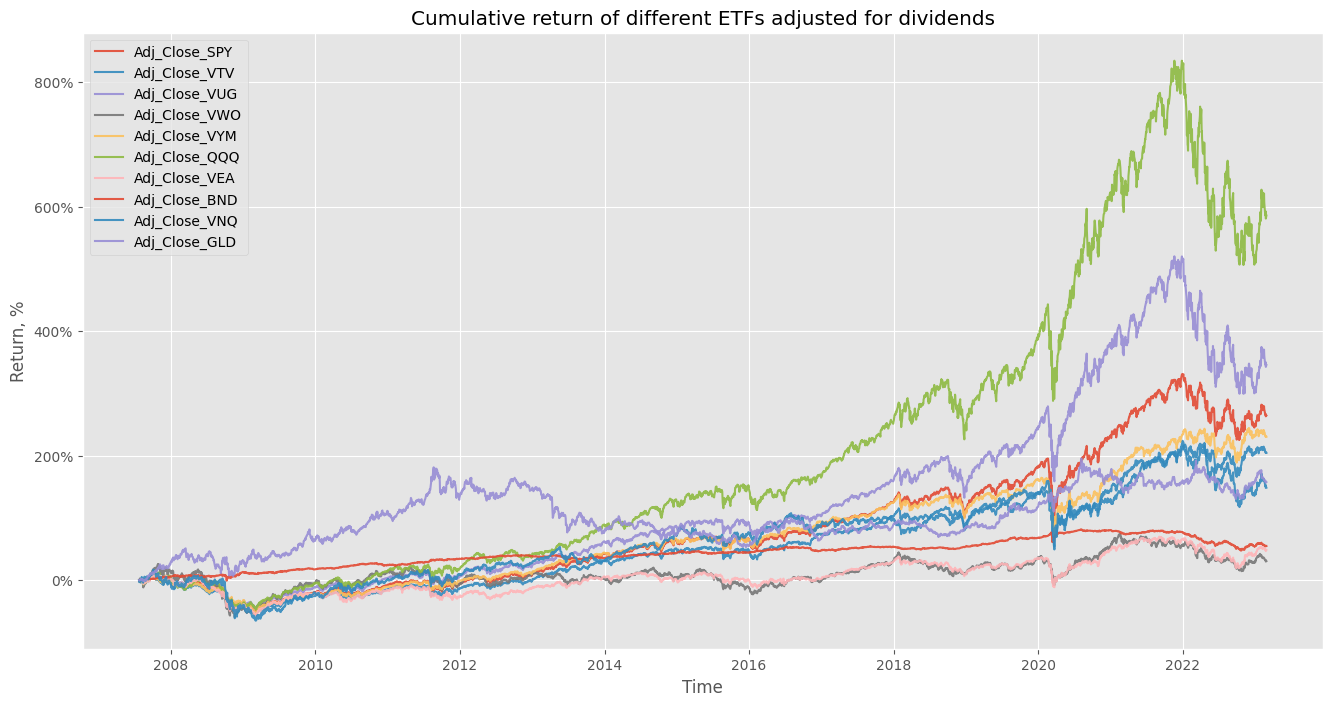

In [5]:
((df_return + 1).cumprod()- 1).plot(figsize=(16,8), alpha=0.9, grid=True, title='Cumulative return of different ETFs adjusted for dividends', xlabel='Time', ylabel='Return, %') 
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:.0%}".format(x)))
plt.show()

### Stocks Correlation <a class="anchor" id="eda_correlation"></a>

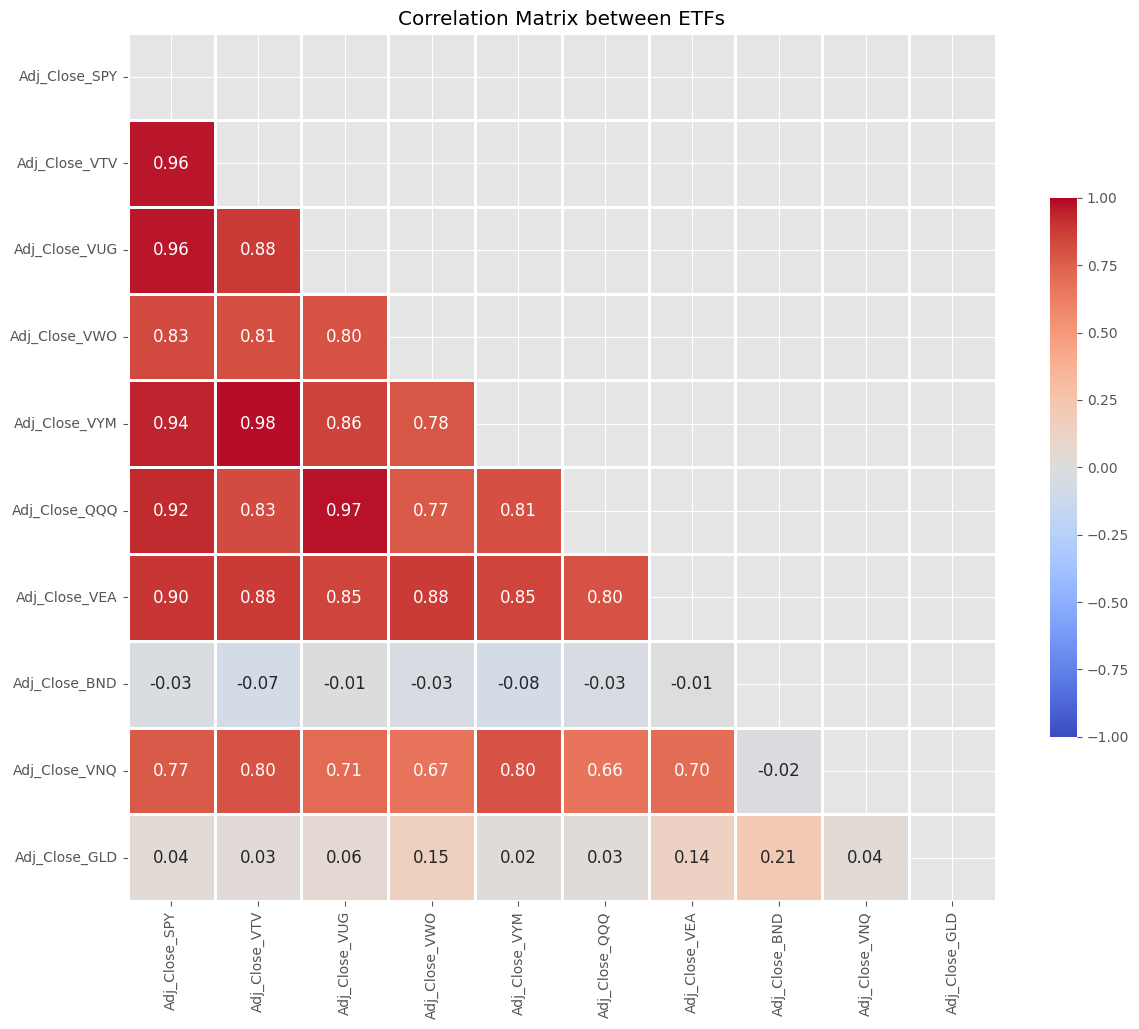

In [6]:
corr = df_return.corr()
triu_mask = np.triu(corr)

plt.figure(figsize=(14, 14))
sns.heatmap(
    corr,
    square=True,
    linewidths=1,
    annot=True,
    mask=triu_mask,
    fmt='.2f',
    cmap='coolwarm',
    vmin=-1,
    vmax=1,
    cbar_kws={'shrink': 0.5},
    annot_kws={'size': 12}
)
plt.title("Correlation Matrix between ETFs")
plt.show()

## Data preparation <a class="anchor" id="embeddings"></a>

In [7]:
# !pip install --quiet ta

In [8]:
from ta.momentum import RSIIndicator, StochasticOscillator, WilliamsRIndicator
from ta.trend import MACD, VortexIndicator
from ta.volatility import UlcerIndex

I use the normalization of featurees across Stocks to have them on the same scale

In [9]:
#normalize 2d array matrix in numpy avoid nan
def normalize(matrix):
    return matrix / (np.nanmax(matrix) - np.nanmin(matrix)), np.nanmax(matrix), np.nanmin(matrix)

Momentum features

In [10]:
rsi_periods = [14, 28]
df_rsi = pd.DataFrame()

for s in stocks:
    for w in rsi_periods:
        df_rsi[f"{s}_RSI_{w}"] = RSIIndicator(
            df_close[f"Close_{s}"], window=w, fillna=False
        ).rsi()


# normalize rsi values across all stocks
temp, rsi_max, rsi_min = normalize(df_rsi.values)

df_rsi = pd.DataFrame(
    temp, columns=df_rsi.columns, index=df_rsi.index
)

assert len(df_rsi) == len(df_return)

df_rsi.tail()

,SPY_RSI_14,SPY_RSI_28,VTV_RSI_14,VTV_RSI_28,VUG_RSI_14,VUG_RSI_28,VWO_RSI_14,VWO_RSI_28,VYM_RSI_14,VYM_RSI_28,QQQ_RSI_14,QQQ_RSI_28,VEA_RSI_14,VEA_RSI_28,BND_RSI_14,BND_RSI_28,VNQ_RSI_14,VNQ_RSI_28,GLD_RSI_14,GLD_RSI_28
3920,0.597172,0.671787,0.562505,0.646975,0.629910,0.687455,0.491597,0.629987,0.547871,0.632864,0.651946,0.700575,0.612262,0.720662,0.436926,0.568597,0.575038,0.661896,0.517445,0.648188
3921,0.590380,0.668201,0.546646,0.638546,0.632809,0.688764,0.470819,0.618076,0.531959,0.624349,0.654752,0.701872,0.570746,0.699337,0.474649,0.584225,0.537957,0.641807,0.483118,0.628808
3922,0.624521,0.682396,0.564478,0.645659,0.666615,0.703870,0.502498,0.629669,0.550024,0.631584,0.688217,0.717183,0.623615,0.718639,0.533654,0.609189,0.581718,0.659624,0.479903,0.626985
3923,0.568767,0.653797,0.531442,0.628702,0.603120,0.670897,0.413918,0.577342,0.526121,0.619346,0.625318,0.684628,0.520845,0.663484,0.479911,0.578981,0.511621,0.621337,0.437418,0.602439
3924,0.591691,0.663180,0.530964,0.628458,0.632744,0.683922,0.457794,0.594207,0.524281,0.618414,0.654025,0.697498,0.612206,0.699588,0.507254,0.590659,0.520738,0.625033,0.482060,0.618454


In [11]:
so_periods = [14, 28]
df_so = pd.DataFrame()

for s in stocks:
    for w in so_periods:
        df_so[f"{s}_SO_{w}"] = StochasticOscillator(
            high=df_high[f"High_{s}"],
            low=df_low[f"Low_{s}"],
            close=df_close[f"Close_{s}"],
            window=w,
            fillna=False,
        ).stoch()

# normalize so values across all stocks
temp, so_max, so_min = normalize(df_so.values)

df_so = pd.DataFrame(
    temp, columns=df_so.columns, index=df_so.index
)

assert len(df_so) == len(df_return)

df_so.tail()


,SPY_SO_14,SPY_SO_28,VTV_SO_14,VTV_SO_28,VUG_SO_14,VUG_SO_28,VWO_SO_14,VWO_SO_28,VYM_SO_14,VYM_SO_28,QQQ_SO_14,QQQ_SO_28,VEA_SO_14,VEA_SO_28,BND_SO_14,BND_SO_28,VNQ_SO_14,VNQ_SO_28,GLD_SO_14,GLD_SO_28
3920,0.013853,0.380998,0.049897,0.250820,0.004302,0.457831,0.000000,0.000000,0.046036,0.144495,0.080917,0.515533,0.011835,0.329318,0.006736,0.006736,0.051724,0.232008,0.090089,0.090089
3921,0.071396,0.363285,0.094863,0.191803,0.065307,0.443016,0.033708,0.027950,0.098486,0.088437,0.080019,0.513520,0.044555,0.171673,0.060606,0.060606,0.046819,0.103837,0.012079,0.011466
3922,0.212838,0.431562,0.217785,0.236064,0.201346,0.507859,0.105023,0.071429,0.213115,0.192797,0.215222,0.576276,0.226744,0.189321,0.199096,0.148149,0.166667,0.177201,0.076088,0.038736
3923,0.119912,0.293720,0.170529,0.161189,0.083863,0.367796,0.059999,0.038363,0.205074,0.187259,0.085797,0.451370,0.087962,0.074218,0.068420,0.042483,0.070288,0.047516,0.021829,0.011817
3924,0.178993,0.337198,0.168875,0.159625,0.177559,0.424380,0.140000,0.089514,0.198732,0.181468,0.185415,0.503895,0.314815,0.265626,0.131579,0.081699,0.091054,0.061555,0.111868,0.060561


In [12]:
wo_periods = [14, 28]

df_wo = pd.DataFrame()

for s in stocks:
    for w in wo_periods:
        df_wo[f"{s}_WO_{w}"] = WilliamsRIndicator(
            high=df_high[f"High_{s}"],
            low=df_low[f"Low_{s}"],
            close=df_close[f"Close_{s}"],
            lbp=w,
            fillna=False,
        ).williams_r()

# normalize wo values across all stocks
temp, wo_max, wo_min = normalize(df_wo.values)

df_wo = pd.DataFrame(
    temp, columns=df_wo.columns, index=df_wo.index
)

assert len(df_wo) == len(df_return)

df_wo.tail()

,SPY_WO_14,SPY_WO_28,VTV_WO_14,VTV_WO_28,VUG_WO_14,VUG_WO_28,VWO_WO_14,VWO_WO_28,VYM_WO_14,VYM_WO_28,QQQ_WO_14,QQQ_WO_28,VEA_WO_14,VEA_WO_28,BND_WO_14,BND_WO_28,VNQ_WO_14,VNQ_WO_28,GLD_WO_14,GLD_WO_28
3920,-0.986147,-0.619002,-0.950103,-0.749180,-0.995698,-0.542169,-1.000000,-1.000000,-0.953964,-0.855505,-0.919083,-0.484467,-0.988165,-0.670682,-0.993264,-0.993264,-0.948276,-0.767992,-0.909911,-0.909911
3921,-0.928604,-0.636715,-0.905137,-0.808197,-0.934693,-0.556984,-0.966292,-0.972050,-0.901514,-0.911563,-0.919981,-0.486480,-0.955445,-0.828327,-0.939394,-0.939394,-0.953181,-0.896163,-0.987921,-0.988534
3922,-0.787162,-0.568438,-0.782215,-0.763936,-0.798654,-0.492141,-0.894977,-0.928571,-0.786885,-0.807203,-0.784778,-0.423724,-0.773256,-0.810679,-0.800904,-0.851851,-0.833333,-0.822799,-0.923912,-0.961264
3923,-0.880088,-0.706280,-0.829471,-0.838811,-0.916137,-0.632204,-0.940001,-0.961637,-0.794926,-0.812741,-0.914203,-0.548630,-0.912037,-0.925782,-0.931580,-0.957517,-0.929712,-0.952484,-0.978171,-0.988183
3924,-0.821007,-0.662802,-0.831125,-0.840375,-0.822441,-0.575620,-0.860000,-0.910486,-0.801268,-0.818532,-0.814585,-0.496105,-0.685185,-0.734374,-0.868421,-0.918301,-0.908946,-0.938445,-0.888132,-0.939439


Trend features

In [13]:
vortex_periods = [14, 28]

df_vortex = pd.DataFrame()

for s in stocks:
    for w in vortex_periods:
        df_vortex[f"{s}_ADX_{w}"] = VortexIndicator(
            high=df_high[f"High_{s}"],
            low=df_low[f"Low_{s}"],
            close=df_close[f"Close_{s}"],
            window=w,
            fillna=False,
        ).vortex_indicator_diff()

# normalize vortex values across all stocks
temp, vortex_max, vortex_min = normalize(df_vortex.values)

df_vortex = pd.DataFrame(
    temp, columns=df_vortex.columns, index=df_vortex.index
)

assert len(df_vortex) == len(df_return)

df_vortex.tail()


,SPY_ADX_14,SPY_ADX_28,VTV_ADX_14,VTV_ADX_28,VUG_ADX_14,VUG_ADX_28,VWO_ADX_14,VWO_ADX_28,VYM_ADX_14,VYM_ADX_28,QQQ_ADX_14,QQQ_ADX_28,VEA_ADX_14,VEA_ADX_28,BND_ADX_14,BND_ADX_28,VNQ_ADX_14,VNQ_ADX_28,GLD_ADX_14,GLD_ADX_28
3920,-0.007508,0.034240,-0.027884,-0.004071,-0.003620,0.051570,-0.071957,-0.006493,-0.036109,-0.014085,0.007845,0.057406,-0.019955,0.041693,-0.093066,-0.030220,-0.044416,0.027761,-0.079803,-0.009047
3921,-0.044310,0.016819,-0.063393,-0.021528,-0.038151,0.037053,-0.119926,-0.022551,-0.069376,-0.029215,-0.026243,0.042561,-0.062277,0.023033,-0.104489,-0.035891,-0.075455,0.003577,-0.111144,-0.012110
3922,-0.085593,0.012069,-0.070477,-0.029236,-0.080519,0.033824,-0.108000,-0.022091,-0.069633,-0.037183,-0.070797,0.041126,-0.075864,0.011181,-0.133942,-0.047554,-0.130299,-0.012674,-0.121900,-0.029262
3923,-0.096285,0.000143,-0.078667,-0.034815,-0.090979,0.018597,-0.101327,-0.044943,-0.078720,-0.043050,-0.082691,0.026883,-0.076433,-0.010882,-0.134409,-0.061765,-0.119984,-0.023189,-0.101078,-0.052016
3924,-0.053438,0.003106,-0.044634,-0.028885,-0.051480,0.018627,-0.065572,-0.035713,-0.045341,-0.036665,-0.043268,0.027929,-0.037807,-0.013994,-0.108439,-0.048082,-0.093452,-0.022238,-0.086789,-0.048067


In [14]:
macd_periods_slow = [26, 36]
macd_periods_fast = [12, 18]
macd_periods_sign = [9, 12]

df_macd = pd.DataFrame()

for s in stocks:
    for sl, f, i in zip(macd_periods_slow, macd_periods_fast, macd_periods_sign):
        df_macd[f"{s}_MACD_{sl}"] = MACD(
            close=df_close[f"Close_{s}"],
            window_slow=sl,
            window_fast=f,
            window_sign=i,
            fillna=False,
        ).macd()

# normalize macd values across all stocks
temp, macd_max, macd_min = normalize(df_macd.values)

df_macd = pd.DataFrame(
    temp, columns=df_macd.columns, index=df_macd.index
)

assert len(df_macd) == len(df_return)

df_macd.tail()

,SPY_MACD_26,SPY_MACD_36,VTV_MACD_26,VTV_MACD_36,VUG_MACD_26,VUG_MACD_36,VWO_MACD_26,VWO_MACD_36,VYM_MACD_26,VYM_MACD_36,QQQ_MACD_26,QQQ_MACD_36,VEA_MACD_26,VEA_MACD_36,BND_MACD_26,BND_MACD_36,VNQ_MACD_26,VNQ_MACD_36,GLD_MACD_26,GLD_MACD_36
3920,0.087218,0.123668,0.004137,0.012756,0.101770,0.128704,-0.004233,0.004054,-0.001660,0.004050,0.147997,0.179056,0.006971,0.015223,-0.009493,-0.003569,0.015018,0.028433,-0.028240,0.007700
3921,0.059053,0.104584,-0.002264,0.008148,0.079457,0.114241,-0.006473,0.001982,-0.006401,0.000598,0.120757,0.161947,0.004440,0.013174,-0.010723,-0.004933,0.006723,0.022437,-0.033641,0.001331
3922,0.041334,0.091059,-0.006613,0.004612,0.065663,0.104299,-0.007822,0.000430,-0.009545,-0.002007,0.104125,0.150452,0.003022,0.011759,-0.010949,-0.005665,0.001687,0.018222,-0.037702,-0.004203
3923,0.016845,0.072587,-0.011603,0.000529,0.044611,0.089194,-0.010614,-0.002057,-0.012846,-0.004809,0.078137,0.132312,0.000218,0.009431,-0.011949,-0.006860,-0.005901,0.012225,-0.043344,-0.010719
3924,0.000663,0.058592,-0.015405,-0.002946,0.031446,0.078366,-0.012207,-0.003847,-0.015358,-0.007199,0.061836,0.119383,-0.000820,0.008152,-0.012311,-0.007650,-0.011471,0.007277,-0.045707,-0.015168


Volatility features

In [15]:
ulcer_periods = [14, 28]

df_ulcer = pd.DataFrame()

for s in stocks:
    for w in ulcer_periods:
        df_ulcer[f"{s}_Ulcer_{w}"] = UlcerIndex(
            close=df_close[f"Close_{s}"], window=w, fillna=False
        ).ulcer_index()

# normalize ulcer values across all stocks
temp, ulcer_max, ulcer_min = normalize(df_ulcer.values)

df_ulcer = pd.DataFrame(
    temp, columns=df_ulcer.columns, index=df_ulcer.index
)

assert len(df_ulcer) == len(df_return)

df_ulcer.tail()


,SPY_Ulcer_14,SPY_Ulcer_28,VTV_Ulcer_14,VTV_Ulcer_28,VUG_Ulcer_14,VUG_Ulcer_28,VWO_Ulcer_14,VWO_Ulcer_28,VYM_Ulcer_14,VYM_Ulcer_28,QQQ_Ulcer_14,QQQ_Ulcer_28,VEA_Ulcer_14,VEA_Ulcer_28,BND_Ulcer_14,BND_Ulcer_28,VNQ_Ulcer_14,VNQ_Ulcer_28,GLD_Ulcer_14,GLD_Ulcer_28
3920,0.047081,0.045115,0.026819,0.033126,0.070439,0.066168,0.106465,0.083624,0.029902,0.041709,0.069851,0.071349,0.045589,0.032795,0.054542,0.039687,0.095866,0.070134,0.123041,0.087824
3921,0.056077,0.047896,0.033613,0.035398,0.081612,0.068174,0.112499,0.090739,0.036447,0.043815,0.080006,0.071536,0.052450,0.037625,0.059324,0.042953,0.109454,0.079415,0.127195,0.093657
3922,0.061139,0.050115,0.038595,0.037396,0.087405,0.069872,0.114348,0.096769,0.041273,0.045703,0.085214,0.071799,0.054374,0.040758,0.061162,0.045426,0.115092,0.086361,0.127840,0.099228
3923,0.068394,0.055442,0.044422,0.040593,0.096601,0.076664,0.116639,0.105652,0.046635,0.048332,0.093534,0.077252,0.059315,0.046865,0.062597,0.048625,0.121956,0.095971,0.126247,0.105587
3924,0.073483,0.059611,0.049409,0.043478,0.102338,0.081828,0.116364,0.112985,0.051368,0.050758,0.098494,0.081296,0.059912,0.050170,0.063187,0.051339,0.127064,0.104462,0.124492,0.110971


In [16]:
df_features = pd.concat(
    [df_rsi, df_so, df_wo, df_vortex, df_macd, df_ulcer], axis=1
)

In [17]:
df_features.index = df_return.index

In [18]:
number_of_features = df_features.shape[1] / len(stocks)
print(f"Number of features: {number_of_features}")

Number of features: 12.0


Cumulative return 14 periods later

In [19]:
future_returns_14 = pd.DataFrame(
    (df_return + 1).cumprod()[14:].values / (df_return + 1).cumprod()[:-14].values - 1,
    columns=df_return.columns,
    index=df_return.index[:-14],
)
future_returns_14.head()

,Adj_Close_SPY,Adj_Close_VTV,Adj_Close_VUG,Adj_Close_VWO,Adj_Close_VYM,Adj_Close_QQQ,Adj_Close_VEA,Adj_Close_BND,Adj_Close_VNQ,Adj_Close_GLD
Date,,,,,,,,,,
2007-07-26,-0.047156,-0.051781,-0.046893,-0.101908,-0.038280,-0.062883,-0.060960,0.003278,-0.041623,0.007311
2007-07-27,-0.020743,-0.016082,-0.032079,-0.107259,-0.013395,-0.052928,-0.050880,0.003950,0.031040,-0.011160
2007-07-30,-0.018116,-0.010498,-0.031099,-0.107355,0.004563,-0.046138,-0.053377,0.007988,0.034430,-0.011555
2007-07-31,-0.007411,0.003942,-0.011965,-0.089418,0.011517,-0.021039,-0.050940,0.003815,0.057613,-0.010184
2007-08-01,-0.010244,-0.006061,-0.017558,-0.081828,0.001713,-0.018371,-0.055093,0.007796,0.048673,-0.013044


Calculate the correlation and covariance matrix

Use 90-days as a period to look back

In [20]:
PERIOD = 90

df_corr = df_return.rolling(PERIOD).corr().reset_index()
df_corr.index = df_corr.Date
df_corr.drop("Date", axis=1, inplace=True)
df_corr = df_corr.dropna()

df_cov = df_return.rolling(PERIOD).cov().reset_index()
df_cov.index = df_cov.Date
df_cov.drop("Date", axis=1, inplace=True)
df_cov = df_cov.dropna()

Unite all indexes to find their intersection

In [21]:
corr_index = df_corr.index.unique()
index = set(corr_index).intersection(set(df_features.index)).intersection(set(future_returns_14.index))
index = sorted(index)
len(index)

3822

In [22]:
df_cov = df_cov.loc[index]
df_corr = df_corr.loc[index]
df_features = df_features.loc[index]

Create embeddings and adjacency matrices

In [23]:
nodes_matrix = np.zeros((len(index), len(stocks), int(number_of_features)))
adj_matrix = np.zeros((len(index), len(stocks), len(stocks)))
cov_matrix = np.zeros((len(index), len(stocks), len(stocks)))


for i, time in tqdm(enumerate(index)):
    #calculate nodes matrix
    for j, stock in enumerate(stocks):
        nodes_matrix[i][j] = df_features.loc[
            time, df_features.columns.str.contains(stock)
        ].to_numpy()

    #calculate adjacency matrix
    corr = df_corr.drop("level_1", axis=1).loc[time].values

    G = nx.from_numpy_array(abs(corr))
    adj_matrix[i] = nx.adjacency_matrix(G).todense()

    #calculate covariance matrix
    cov_matrix[i] = df_cov.drop("level_1", axis=1).loc[time].values * np.sqrt(PERIOD)

future_returns_matrix = future_returns_14.loc[index].values

assert len(future_returns_matrix) == len(nodes_matrix) == len(adj_matrix) == len(cov_matrix)

3822it [01:03, 60.10it/s] 


## Neural Networks <a class="anchor" id="nn"></a>

Create DataLoader

In [24]:
class MyDataset(Dataset):
    """
    Args:
    nodes_embs: torch.Tensor, shape (#time_periods, #nodes, #embds_length)
    adj_list: torch.Tensor, shape (#time_periods, #nodes, #nodes)
    cov_matrix: torch.Tensor, shape (#time_periods, #nodes, #nodes)
    future_returns: torch.Tensor, shape (#time_periods, #nodes)
    Returns:
    nodes_embs: torch.Tensor, shape (#nodes, #embds_length)
    edge_index: torch.tensor, shape (2, #edges)
    edge_attr: torch.Tensor, shape (#edges)
    cov_matrix: torch.Tensor, shape (#nodes, #nodes)
    future_returns: torch.Tensor, shape (#nodes)
    """

    def __init__(self, nodes_embs, adj_list, cov_matrix, future_returns):
        self.nodes_embs = torch.tensor(nodes_embs, dtype=torch.float32)
        self.adj_matrix = torch.tensor(adj_list, dtype=torch.float32)
        self.edge_time_index = MyDataset.convert_to_index(self.adj_matrix)
        self.edge_attr = MyDataset.create_attr(self.adj_matrix)
        self.cov_matrix = torch.tensor(cov_matrix, dtype=torch.float32)
        self.future_returns = torch.tensor(future_returns, dtype=torch.float32)

        self.num_features = nodes_embs.shape[2]
        self.num_nodes = nodes_embs.shape[1]
        self.num_time_periods = nodes_embs.shape[0]

    @staticmethod
    def convert_to_index(adj_matrix):
        return adj_matrix.nonzero().t().contiguous()

    @staticmethod
    def create_attr(adj_matrix):
        return adj_matrix[torch.where(adj_matrix != 0)]

    def __getitem__(self, idx):
        node_emb = self.nodes_embs[idx, :, :]
        edge_index = self.edge_time_index[1:, self.edge_time_index[0] == idx]
        edge_attr = self.edge_attr[self.edge_time_index[0] == idx]
        cov_matrix = self.cov_matrix[idx, :, :]
        future_returns = self.future_returns[idx, :]

        return node_emb, edge_index, edge_attr, cov_matrix, future_returns

    def __len__(self):
        return self.num_time_periods

Divide into train / val split

in order to have non-overlapping periods I take 90-period (equal to covariance matirx window) break between train and validation sets

In [25]:
TRAIN = 2800
PERIOD = 90

train_dataset = MyDataset(nodes_matrix[:TRAIN], adj_matrix[:TRAIN], cov_matrix[:TRAIN], future_returns_matrix[:TRAIN])
train_sampler = SequentialSampler(train_dataset)
train_loader = DataLoader(dataset=train_dataset, shuffle=False, batch_size=1, sampler=train_sampler)

test_dataset = MyDataset(nodes_matrix[TRAIN+90:], adj_matrix[TRAIN+90:], cov_matrix[TRAIN+90:], future_returns_matrix[TRAIN+90:])
test_sampler = SequentialSampler(test_dataset)
test_loader = DataLoader(dataset=test_dataset, shuffle=False, batch_size=1, sampler=test_sampler)

print(len(train_loader), len(test_loader))

2800 932


### Create Optimization Layer (Sharpe Ratio) <a class="anchor" id="optimization"></a>


As was shown in this [paper](https://people.stat.sc.edu/sshen/events/backtesting/reference/maximizing%20the%20sharpe%20ratio.pdf) the task of optimizing Shapre ratio

<img src="img/sharpe_1.png" alt="Sharpe 1" style="height: 200px;"/>

can be reformulated to a much simpler task

<img src="img/sharpe_2.png" alt="Sharpe 1" style="height: 200px;"/>

subject to $y = \lambda * x$

In [26]:
import cvxpy as cp
from cvxpylayers.torch import CvxpyLayer

In [27]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [28]:
class OptimizationLayer2(torch.nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, pred_return, cov_matrix):
        n = len(pred_return)

        b = pred_return.detach().cpu().numpy()
        A = cov_matrix.numpy()

        x = cp.Variable(n)

        constraints = [x >= 0, b.T @ x == 1]
        problem = cp.Problem(cp.Minimize(cp.sum_squares(A @ x)), constraints)
        try:
            problem.solve(solver=cp.ECOS, verbose=False)
        except:
            w = np.ones(n) / n
            flag = 1
            return w, flag
            
        # flag if the problem is infeasible        
        if x.value is None:
            w = np.ones(n) / n
            flag = 1
        else:
            w = x.value / sum(x.value)
            flag = 0
        
        return w, flag

### Create Optimization Layer (Risk Budgeting) <a class="anchor" id="optimization_risk"></a>

The idea behind risk-budgeting is to allocate weights according to risk contribution to the portfolio. Risk-parity is a special case of the risk-budgeting approach. It is vital to remeber, that we are no longer interested in maximizing returns in this case.

As was formulated in [End-to-End Risk Budgeting Portfolio Optimization with Neural Networks](https://arxiv.org/abs/2107.04636) the problem we are facing is 

<img src="img/optimization_risk.png" alt="Schema 2" style="height: 200px;"/>

where $b_i$ stands for the output of a prediction layer (risk-budget of $asset_i$), $y_i$ weights to optimize, $W$ - a covariance matrix. Final weights are obtained as $x_i=\frac{y_i}{\sum_{i}^{}y_i}$

In [29]:
class OptimizationLayerBudgetingTest(torch.nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, log_risk_budget, cov_matrix):
        n = len(log_risk_budget)

        x = cp.Variable(n)
        A = cp.Parameter((n, n), PSD=True)  # cov_matrix
        b = cp.Parameter(n)  # predicted risk budget

        x = cp.Variable(n)
        t = cp.Variable(1)
        c = cp.Variable(n)

        constraints = [x >= 0 , b.T @ c >= 0, cp.sum_squares(A @ x) <= t, c <= cp.log(x)]

        problem = cp.Problem(cp.Minimize(t), constraints)
        layer1 = CvxpyLayer(problem, parameters=[A, b], variables=[x, t, c])

        #if the problem is infeasible, return uniform weights
        try:
            x, t, c = layer1(cov_matrix, log_risk_budget) 
            w = softmax(x) # normalized weights
            return w, 0
        except:
            w = (torch.ones(n) / n).type(torch.float32).to(device)
            return w, 1

In order to speed up the convergence I developd an aproximate optimization layer using $log(x) = \log(a) + \frac{x-a}{a}$, since x is not supposed to be big, we can assign a small value to a. Let's say that $a = \frac{1}{assets}$ 

In [30]:
class OptimizationLayerBudgetingApproximation(torch.nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, log_risk_budget, cov_matrix, a = 0.1):
        n = len(log_risk_budget)

        x = cp.Variable(n)
        A = cp.Parameter((n, n), PSD=True)  # cov_matrix
        b = cp.Parameter(n)  # predicted risk budget

        x = cp.Variable(n)
        t = cp.Variable(1)

        constraints = [x >= 0 , b.T @ (cp.log(a) + (x-a)/a) >= 0, cp.sum_squares(A @ x) <= t]

        problem = cp.Problem(cp.Minimize(t), constraints)
        layer1 = CvxpyLayer(problem, parameters=[A, b], variables=[x, t])

        #if the problem is infeasible, return uniform weights
        try:
            x, _ = layer1(cov_matrix, log_risk_budget) 
            w = softmax(x) # normalized weights
            return w, 0
        except:
            w = (torch.ones(n) / n).type(torch.float32).to(device)
            return w, 1

### Simple Model <a class="anchor" id="simple"></a>

In [31]:
class SimpleModel(torch.nn.Module):
    def __init__(self, num_features):
        super().__init__()
        self.gat1 = GATConv(num_features, 2 * num_features, dropout=0.3)
        self.gat2 = GATConv(2 * num_features, 1, dropout=0.3)
        self.relu = torch.nn.ReLU()

    def forward(self, node_embs, edge_index, edge_attr):
        node_embs = node_embs.squeeze(0)
        edge_index = edge_index.squeeze(0)
        edge_attr = edge_attr.squeeze(0)

        x = self.gat1(node_embs, edge_index, edge_attr)
        x = self.relu(x)
        pred_return = self.gat2(x, edge_index, edge_attr).squeeze(1)

        return pred_return

### Deeper Model <a class="anchor" id="deeper"></a>

In [32]:
class DeeperModel(torch.nn.Module):
    def __init__(self, num_features):
        super().__init__()
        self.gat1 = GATConv(num_features, 2 * num_features, dropout=0.3)
        self.gat2 = GATConv(2 * num_features, 4*num_features, dropout=0.3)
        self.gat3 = GATConv(4 * num_features, 2*num_features, dropout=0.3)
        self.gat4 = GATConv(2 * num_features, num_features, dropout=0.3)
        self.gat5 = GATConv(num_features, 1, dropout=0.3)
        self.relu = torch.nn.ReLU()      

    def forward(self, node_embs, edge_index, edge_attr):
        node_embs = node_embs.squeeze(0)
        edge_index = edge_index.squeeze(0)
        edge_attr = edge_attr.squeeze(0)

        x = self.gat1(node_embs, edge_index, edge_attr)
        x = self.relu(x)
        x = self.gat2(x, edge_index, edge_attr)
        x = self.relu(x)
        x = self.gat3(x, edge_index, edge_attr)
        x = self.relu(x)
        x = self.gat4(x, edge_index, edge_attr)
        x = self.relu(x)
        pred_return = self.gat5(x, edge_index, edge_attr).squeeze(1)

        return pred_return

### Simple Model (Risk Budgeting) <a class="anchor" id="simple_risk"></a>

In [33]:
class SimpleModelBudgeting(torch.nn.Module):
    def __init__(self, num_features):
        super().__init__()
        self.gat1 = GATConv(num_features, 2 * num_features, dropout=0.3)
        self.gat2 = GATConv(2 * num_features, 1, dropout=0.3)
        self.relu = torch.nn.ReLU()

    def forward(self, node_embs, edge_index, edge_attr):
        node_embs = node_embs.squeeze(0)
        edge_index = edge_index.squeeze(0)
        edge_attr = edge_attr.squeeze(0)

        x = self.gat1(node_embs, edge_index, edge_attr)
        x = self.relu(x)
        x = self.gat2(x, edge_index, edge_attr).squeeze(1)

        risk_budgets = softmax(x)

        return risk_budgets

### Deeper Model (Risk Budgeting) <a class="anchor" id="deeper_risk"></a>

In [34]:
class DeeperModelBudgeting(torch.nn.Module):
    def __init__(self, num_features):
        super().__init__()
        self.gat1 = GATConv(num_features, 2 * num_features, dropout=0.3)
        self.gat2 = GATConv(2 * num_features, 4*num_features, dropout=0.3)
        self.gat3 = GATConv(4 * num_features, 2*num_features, dropout=0.3)
        self.gat4 = GATConv(2 * num_features, num_features, dropout=0.3)
        self.gat5 = GATConv(num_features, 1, dropout=0.3)
        self.relu = torch.nn.ReLU()

    def forward(self, node_embs, edge_index, edge_attr):
        node_embs = node_embs.squeeze(0)
        edge_index = edge_index.squeeze(0)
        edge_attr = edge_attr.squeeze(0)

        x = self.gat1(node_embs, edge_index, edge_attr)
        x = self.relu(x)
        x = self.gat2(x, edge_index, edge_attr)
        x = self.relu(x)
        x = self.gat3(x, edge_index, edge_attr)
        x = self.relu(x)
        x = self.gat4(x, edge_index, edge_attr)
        x = self.relu(x)
        x = self.gat5(x, edge_index, edge_attr).squeeze(1)

        risk_budgets = softmax(x)

        return risk_budgets

## Training <a class="anchor" id="training"></a>

In [35]:
#fix torch random state
torch.manual_seed(45)

In [36]:
def max_return_loss(weights, returns):
    return -torch.sum(weights * returns)

In [37]:
from torch.nn.functional import l1_loss, mse_loss

In [38]:
from prettytable import PrettyTable

def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        params = parameter.numel()
        table.add_row([name, params])
        total_params+=params
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params


### Simple <a class="anchor" id="training_simple"></a>
#### L1 loss

In [39]:
model = SimpleModel(int(number_of_features))
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
count_parameters(model)

+---------------------+------------+
|       Modules       | Parameters |
+---------------------+------------+
|     gat1.att_src    |     24     |
|     gat1.att_dst    |     24     |
|      gat1.bias      |     24     |
| gat1.lin_src.weight |    288     |
|     gat2.att_src    |     1      |
|     gat2.att_dst    |     1      |
|      gat2.bias      |     1      |
| gat2.lin_src.weight |     24     |
+---------------------+------------+
Total Trainable Params: 387


387

In [40]:
counter_faulty = 0
EPOCHS = 2
step = 0

model = model.to(device)
model.train()

for epoch in range(EPOCHS):
    for i, (node_emb, edge_index, edge_attr, cov, future_returns) in enumerate(train_loader):
        
        node_emb = node_emb.to(device)
        edge_index = edge_index.to(device)
        edge_attr = edge_attr.to(device)
        future_returns = future_returns.to(device)
        
        optimizer.zero_grad()
        
        pred_return = model(node_emb, edge_index, edge_attr)
        weights, flag = OptimizationLayer2()(pred_return, cov.squeeze(0))
        counter_faulty += flag

        loss = l1_loss(pred_return, future_returns.squeeze(0), reduction='mean')
        loss.backward()
        optimizer.step()
        step+=1

        if i % 100 == 0:
            print("EPOCH", epoch, "iteration", i, "loss:", loss.cpu().detach().numpy(), "share of faulty:", round(counter_faulty / step, 2))


EPOCH 0 iteration 0 loss: 0.12697028 share of faulty: 1.0
EPOCH 0 iteration 100 loss: 0.017305113 share of faulty: 0.48
EPOCH 0 iteration 200 loss: 0.096613556 share of faulty: 0.47
EPOCH 0 iteration 300 loss: 0.077372886 share of faulty: 0.55
EPOCH 0 iteration 400 loss: 0.07028614 share of faulty: 0.48
EPOCH 0 iteration 500 loss: 0.01686194 share of faulty: 0.45
EPOCH 0 iteration 600 loss: 0.046980686 share of faulty: 0.43
EPOCH 0 iteration 700 loss: 0.060853817 share of faulty: 0.44
EPOCH 0 iteration 800 loss: 0.03592752 share of faulty: 0.42
EPOCH 0 iteration 900 loss: 0.01799893 share of faulty: 0.42
EPOCH 0 iteration 1000 loss: 0.07597973 share of faulty: 0.42
EPOCH 0 iteration 1100 loss: 0.0135783525 share of faulty: 0.41
EPOCH 0 iteration 1200 loss: 0.03342588 share of faulty: 0.4
EPOCH 0 iteration 1300 loss: 0.024206638 share of faulty: 0.4
EPOCH 0 iteration 1400 loss: 0.032239936 share of faulty: 0.39
EPOCH 0 iteration 1500 loss: 0.023314808 share of faulty: 0.39
EPOCH 0 itera

In [41]:
weights_matrix_test = np.zeros((len(test_loader), len(stocks)))
counter_faulty = 0

model.eval()
with torch.no_grad():
    
    for i, (node_emb, edge_index, edge_attr, cov, future_returns) in enumerate(test_loader):

        node_emb = node_emb.to(device)
        edge_index = edge_index.to(device)
        edge_attr = edge_attr.to(device)
        future_returns = future_returns.to(device)
        
        pred_return = model(node_emb, edge_index, edge_attr)
        weights, flag = OptimizationLayer2()(pred_return, cov.squeeze(0))
        weights_matrix_test[i] = weights
        counter_faulty += flag

        loss = l1_loss(pred_return, future_returns.squeeze(0), reduction='mean')

        if i % 100 == 0:
            print("EPOCH", epoch, "iteration", i, "loss:", loss.cpu().detach().numpy(), "share of faulty:", round(counter_faulty / (i+1), 2))
    

EPOCH 1 iteration 0 loss: 0.042521942 share of faulty: 1.0
EPOCH 1 iteration 100 loss: 0.079828754 share of faulty: 0.98
EPOCH 1 iteration 200 loss: 0.259314 share of faulty: 0.94
EPOCH 1 iteration 300 loss: 0.15301439 share of faulty: 0.81
EPOCH 1 iteration 400 loss: 0.11883348 share of faulty: 0.84
EPOCH 1 iteration 500 loss: 0.104612865 share of faulty: 0.87
EPOCH 1 iteration 600 loss: 0.035674173 share of faulty: 0.88
EPOCH 1 iteration 700 loss: 0.04625524 share of faulty: 0.85
EPOCH 1 iteration 800 loss: 0.058115352 share of faulty: 0.76
EPOCH 1 iteration 900 loss: 0.09664361 share of faulty: 0.74


#### L2 loss

In [42]:
model_l2 = SimpleModel(int(number_of_features))
optimizer = torch.optim.Adam(model_l2.parameters(), lr=0.001)
count_parameters(model_l2)

+---------------------+------------+
|       Modules       | Parameters |
+---------------------+------------+
|     gat1.att_src    |     24     |
|     gat1.att_dst    |     24     |
|      gat1.bias      |     24     |
| gat1.lin_src.weight |    288     |
|     gat2.att_src    |     1      |
|     gat2.att_dst    |     1      |
|      gat2.bias      |     1      |
| gat2.lin_src.weight |     24     |
+---------------------+------------+
Total Trainable Params: 387


387

In [43]:
counter_faulty = 0
EPOCHS = 2
step = 0

model_l2 = model_l2.to(device)
model_l2.train()

for epoch in range(EPOCHS):
    for i, (node_emb, edge_index, edge_attr, cov, future_returns) in enumerate(train_loader):
        
        node_emb = node_emb.to(device)
        edge_index = edge_index.to(device)
        edge_attr = edge_attr.to(device)
        future_returns = future_returns.to(device)
        
        optimizer.zero_grad()
        
        pred_return = model_l2(node_emb, edge_index, edge_attr)
        weights, flag = OptimizationLayer2()(pred_return, cov.squeeze(0))
        counter_faulty += flag

        loss = mse_loss(pred_return, future_returns.squeeze(0), reduction='mean')
        loss.backward()
        optimizer.step()
        step+=1

        if i % 100 == 0:
            print("EPOCH", epoch, "iteration", i, "loss:", loss.cpu().detach().numpy(), "share of faulty:", round(counter_faulty / step, 2))

EPOCH 0 iteration 0 loss: 0.04456397 share of faulty: 1.0
EPOCH 0 iteration 100 loss: 0.0018473796 share of faulty: 0.46
EPOCH 0 iteration 200 loss: 0.005090956 share of faulty: 0.49
EPOCH 0 iteration 300 loss: 0.0069453754 share of faulty: 0.52
EPOCH 0 iteration 400 loss: 0.004674253 share of faulty: 0.47
EPOCH 0 iteration 500 loss: 0.00061184575 share of faulty: 0.44
EPOCH 0 iteration 600 loss: 0.0027674185 share of faulty: 0.43
EPOCH 0 iteration 700 loss: 0.012381698 share of faulty: 0.43
EPOCH 0 iteration 800 loss: 0.0005427871 share of faulty: 0.41
EPOCH 0 iteration 900 loss: 0.004984588 share of faulty: 0.41
EPOCH 0 iteration 1000 loss: 0.0005005637 share of faulty: 0.42
EPOCH 0 iteration 1100 loss: 0.00035306654 share of faulty: 0.4
EPOCH 0 iteration 1200 loss: 0.0006585206 share of faulty: 0.39
EPOCH 0 iteration 1300 loss: 0.00089412055 share of faulty: 0.38
EPOCH 0 iteration 1400 loss: 0.00087080663 share of faulty: 0.37
EPOCH 0 iteration 1500 loss: 0.0005953896 share of fault

In [44]:
weights_matrix_test_l2 = np.zeros((len(test_loader), len(stocks)))
counter_faulty = 0

model_l2.eval()
with torch.no_grad():
    
    for i, (node_emb, edge_index, edge_attr, cov, future_returns) in enumerate(test_loader):

        node_emb = node_emb.to(device)
        edge_index = edge_index.to(device)
        edge_attr = edge_attr.to(device)
        future_returns = future_returns.to(device)
        
        pred_return = model_l2(node_emb, edge_index, edge_attr)
        weights, flag = OptimizationLayer2()(pred_return, cov.squeeze(0))
        weights_matrix_test_l2[i] = weights
        counter_faulty += flag

        loss = mse_loss(pred_return, future_returns.squeeze(0), reduction='mean')

        if i % 100 == 0:
            print("EPOCH", epoch, "iteration", i, "loss:", loss.cpu().detach().numpy(), "share of faulty:", round(counter_faulty / (i+1), 2))

EPOCH 1 iteration 0 loss: 0.0075287707 share of faulty: 0.0
EPOCH 1 iteration 100 loss: 0.00031485036 share of faulty: 0.12
EPOCH 1 iteration 200 loss: 0.035790205 share of faulty: 0.27
EPOCH 1 iteration 300 loss: 0.0028427418 share of faulty: 0.29
EPOCH 1 iteration 400 loss: 0.0008582873 share of faulty: 0.29
EPOCH 1 iteration 500 loss: 0.0006200223 share of faulty: 0.29
EPOCH 1 iteration 600 loss: 0.002518813 share of faulty: 0.28
EPOCH 1 iteration 700 loss: 0.008372927 share of faulty: 0.25
EPOCH 1 iteration 800 loss: 0.0003954066 share of faulty: 0.22
EPOCH 1 iteration 900 loss: 0.0030843648 share of faulty: 0.21


### Deeper <a class="anchor" id="training_deeper"></a>
#### L1 loss

In [45]:
deeper_model = DeeperModel(int(number_of_features))
optimizer = torch.optim.Adam(deeper_model.parameters(), lr=0.001)
count_parameters(deeper_model)

+---------------------+------------+
|       Modules       | Parameters |
+---------------------+------------+
|     gat1.att_src    |     24     |
|     gat1.att_dst    |     24     |
|      gat1.bias      |     24     |
| gat1.lin_src.weight |    288     |
|     gat2.att_src    |     48     |
|     gat2.att_dst    |     48     |
|      gat2.bias      |     48     |
| gat2.lin_src.weight |    1152    |
|     gat3.att_src    |     24     |
|     gat3.att_dst    |     24     |
|      gat3.bias      |     24     |
| gat3.lin_src.weight |    1152    |
|     gat4.att_src    |     12     |
|     gat4.att_dst    |     12     |
|      gat4.bias      |     12     |
| gat4.lin_src.weight |    288     |
|     gat5.att_src    |     1      |
|     gat5.att_dst    |     1      |
|      gat5.bias      |     1      |
| gat5.lin_src.weight |     12     |
+---------------------+------------+
Total Trainable Params: 3219


3219

In [46]:
counter_faulty = 0
EPOCHS = 2
step = 0

deeper_model = deeper_model.to(device)
deeper_model.train()

for epoch in range(EPOCHS):
    for i, (node_emb, edge_index, edge_attr, cov, future_returns) in enumerate(train_loader):
        
        node_emb = node_emb.to(device)
        edge_index = edge_index.to(device)
        edge_attr = edge_attr.to(device)
        future_returns = future_returns.to(device)
        
        optimizer.zero_grad()
        
        pred_return = deeper_model(node_emb, edge_index, edge_attr)
        weights, flag = OptimizationLayer2()(pred_return, cov.squeeze(0))
        counter_faulty += flag

        loss = l1_loss(pred_return, future_returns.squeeze(0), reduction='mean')
        loss.backward()
        optimizer.step()
        step+=1

        if i % 100 == 0:
            print("EPOCH", epoch, "iteration", i, "loss:", loss.cpu().detach().numpy(), "share of faulty:", round(counter_faulty / step, 2))

EPOCH 0 iteration 0 loss: 0.07395959 share of faulty: 0.0
EPOCH 0 iteration 100 loss: 0.0140221175 share of faulty: 0.54
EPOCH 0 iteration 200 loss: 0.10750224 share of faulty: 0.6
EPOCH 0 iteration 300 loss: 0.11847057 share of faulty: 0.61
EPOCH 0 iteration 400 loss: 0.09586603 share of faulty: 0.55
EPOCH 0 iteration 500 loss: 0.022450414 share of faulty: 0.49
EPOCH 0 iteration 600 loss: 0.04836062 share of faulty: 0.46
EPOCH 0 iteration 700 loss: 0.04467664 share of faulty: 0.47
EPOCH 0 iteration 800 loss: 0.019894283 share of faulty: 0.43
EPOCH 0 iteration 900 loss: 0.043284237 share of faulty: 0.42
EPOCH 0 iteration 1000 loss: 0.05700209 share of faulty: 0.43
EPOCH 0 iteration 1100 loss: 0.0146337245 share of faulty: 0.41
EPOCH 0 iteration 1200 loss: 0.023261875 share of faulty: 0.41
EPOCH 0 iteration 1300 loss: 0.028778693 share of faulty: 0.4
EPOCH 0 iteration 1400 loss: 0.06400211 share of faulty: 0.39
EPOCH 0 iteration 1500 loss: 0.024454053 share of faulty: 0.38
EPOCH 0 itera

In [47]:
weights_matrix_test_2 = np.zeros((len(test_loader), len(stocks)))
counter_faulty = 0

deeper_model.eval()
with torch.no_grad():
    
    for i, (node_emb, edge_index, edge_attr, cov, future_returns) in enumerate(test_loader):
        
        node_emb = node_emb.to(device)
        edge_index = edge_index.to(device)
        edge_attr = edge_attr.to(device)
        future_returns = future_returns.to(device)
        
        pred_return = deeper_model(node_emb, edge_index, edge_attr)
        weights, flag = OptimizationLayer2()(pred_return, cov.squeeze(0))
        counter_faulty += flag

        loss = l1_loss(pred_return, future_returns.squeeze(0), reduction='mean')
        weights_matrix_test_2[i] = weights
        
        if i % 100 == 0:
            print("EPOCH", epoch, "iteration", i, "loss:", loss.cpu().detach().numpy(), "share of faulty:", round(counter_faulty / (i+1), 2))

EPOCH 1 iteration 0 loss: 0.00786745 share of faulty: 0.0
EPOCH 1 iteration 100 loss: 0.047816705 share of faulty: 0.7
EPOCH 1 iteration 200 loss: 0.12691309 share of faulty: 0.79
EPOCH 1 iteration 300 loss: 0.07464664 share of faulty: 0.75
EPOCH 1 iteration 400 loss: 0.06489724 share of faulty: 0.76
EPOCH 1 iteration 500 loss: 0.059088342 share of faulty: 0.79
EPOCH 1 iteration 600 loss: 0.020549882 share of faulty: 0.8
EPOCH 1 iteration 700 loss: 0.04011743 share of faulty: 0.76
EPOCH 1 iteration 800 loss: 0.052686352 share of faulty: 0.69
EPOCH 1 iteration 900 loss: 0.036101263 share of faulty: 0.67


#### L2 loss

In [48]:
deeper_model_l2 = DeeperModel(int(number_of_features))
optimizer = torch.optim.Adam(deeper_model_l2.parameters(), lr=0.001)
count_parameters(deeper_model_l2)

+---------------------+------------+
|       Modules       | Parameters |
+---------------------+------------+
|     gat1.att_src    |     24     |
|     gat1.att_dst    |     24     |
|      gat1.bias      |     24     |
| gat1.lin_src.weight |    288     |
|     gat2.att_src    |     48     |
|     gat2.att_dst    |     48     |
|      gat2.bias      |     48     |
| gat2.lin_src.weight |    1152    |
|     gat3.att_src    |     24     |
|     gat3.att_dst    |     24     |
|      gat3.bias      |     24     |
| gat3.lin_src.weight |    1152    |
|     gat4.att_src    |     12     |
|     gat4.att_dst    |     12     |
|      gat4.bias      |     12     |
| gat4.lin_src.weight |    288     |
|     gat5.att_src    |     1      |
|     gat5.att_dst    |     1      |
|      gat5.bias      |     1      |
| gat5.lin_src.weight |     12     |
+---------------------+------------+
Total Trainable Params: 3219


3219

In [49]:
counter_faulty = 0
EPOCHS = 2
step = 0

deeper_model_l2 = deeper_model_l2.to(device)
deeper_model_l2.train()

for epoch in range(EPOCHS):
    for i, (node_emb, edge_index, edge_attr, cov, future_returns) in enumerate(train_loader):
        
        node_emb = node_emb.to(device)
        edge_index = edge_index.to(device)
        edge_attr = edge_attr.to(device)
        future_returns = future_returns.to(device)
        
        optimizer.zero_grad()
        
        pred_return = deeper_model_l2(node_emb, edge_index, edge_attr)
        weights, flag = OptimizationLayer2()(pred_return, cov.squeeze(0))
        counter_faulty += flag

        loss = mse_loss(pred_return, future_returns.squeeze(0), reduction='mean')
        loss.backward()
        optimizer.step()
        step+=1

        if i % 100 == 0:
            print("EPOCH", epoch, "iteration", i, "loss:", loss.cpu().detach().numpy(), "share of faulty:", round(counter_faulty / step, 2))

EPOCH 0 iteration 0 loss: 0.014608502 share of faulty: 0.0
EPOCH 0 iteration 100 loss: 0.00038518925 share of faulty: 0.53
EPOCH 0 iteration 200 loss: 0.0096937865 share of faulty: 0.6
EPOCH 0 iteration 300 loss: 0.0067207264 share of faulty: 0.61
EPOCH 0 iteration 400 loss: 0.011456123 share of faulty: 0.54
EPOCH 0 iteration 500 loss: 0.00047562667 share of faulty: 0.49
EPOCH 0 iteration 600 loss: 0.002710655 share of faulty: 0.43
EPOCH 0 iteration 700 loss: 0.0019559744 share of faulty: 0.45
EPOCH 0 iteration 800 loss: 0.0006432283 share of faulty: 0.41
EPOCH 0 iteration 900 loss: 0.0006729291 share of faulty: 0.39
EPOCH 0 iteration 1000 loss: 0.015623574 share of faulty: 0.41
EPOCH 0 iteration 1100 loss: 0.00035411507 share of faulty: 0.4
EPOCH 0 iteration 1200 loss: 0.00059675745 share of faulty: 0.39
EPOCH 0 iteration 1300 loss: 0.000770172 share of faulty: 0.38
EPOCH 0 iteration 1400 loss: 0.0022687153 share of faulty: 0.36
EPOCH 0 iteration 1500 loss: 0.0007586061 share of fault

In [50]:
weights_matrix_test_l2_2 = np.zeros((len(test_loader), len(stocks)))
counter_faulty = 0

deeper_model_l2.eval()
with torch.no_grad():
    
    for i, (node_emb, edge_index, edge_attr, cov, future_returns) in enumerate(test_loader):
        
        node_emb = node_emb.to(device)
        edge_index = edge_index.to(device)
        edge_attr = edge_attr.to(device)
        future_returns = future_returns.to(device)
        
        pred_return = deeper_model_l2(node_emb, edge_index, edge_attr)
        weights, flag = OptimizationLayer2()(pred_return, cov.squeeze(0))
        counter_faulty += flag

        loss = mse_loss(pred_return, future_returns.squeeze(0), reduction='mean')
        weights_matrix_test_l2_2[i] = weights
        
        if i % 100 == 0:
            print("EPOCH", epoch, "iteration", i, "loss:", loss.cpu().detach().numpy(), "share of faulty:", round(counter_faulty / (i+1), 2))

EPOCH 1 iteration 0 loss: 0.001083785 share of faulty: 1.0
EPOCH 1 iteration 100 loss: 0.0036655888 share of faulty: 0.95
EPOCH 1 iteration 200 loss: 0.10292842 share of faulty: 0.92
EPOCH 1 iteration 300 loss: 0.0077834763 share of faulty: 0.84
EPOCH 1 iteration 400 loss: 0.0073702224 share of faulty: 0.86
EPOCH 1 iteration 500 loss: 0.0055704424 share of faulty: 0.88
EPOCH 1 iteration 600 loss: 0.0008582496 share of faulty: 0.88
EPOCH 1 iteration 700 loss: 0.008679971 share of faulty: 0.85
EPOCH 1 iteration 800 loss: 0.0030458667 share of faulty: 0.78
EPOCH 1 iteration 900 loss: 0.004872967 share of faulty: 0.75


A preliminatary conclusion is that optimization of Sharpe ratio often fails and should be reconsidered.

### Simple Model (Risk Budgeting) <a class="anchor" id="training_simple_risk"></a>

Due to numerical complexity and longer time of optimization, for this notebook I will Use an Approximate Optimization.

In [51]:
model_budgeting = SimpleModelBudgeting(int(number_of_features))
optimizer = torch.optim.Adam(model_budgeting.parameters(), lr=0.001)
count_parameters(model_budgeting)

+---------------------+------------+
|       Modules       | Parameters |
+---------------------+------------+
|     gat1.att_src    |     24     |
|     gat1.att_dst    |     24     |
|      gat1.bias      |     24     |
| gat1.lin_src.weight |    288     |
|     gat2.att_src    |     1      |
|     gat2.att_dst    |     1      |
|      gat2.bias      |     1      |
| gat2.lin_src.weight |     24     |
+---------------------+------------+
Total Trainable Params: 387


387

In [52]:
counter_faulty = 0
EPOCHS = 2
step = 0

model_budgeting = model_budgeting.to(device)
model_budgeting.train()

for epoch in range(EPOCHS):
    
    for i, (node_emb, edge_index, edge_attr, cov, future_returns) in enumerate(train_loader):
        
        node_emb = node_emb.to(device)
        edge_index = edge_index.to(device)
        edge_attr = edge_attr.to(device)
        future_returns = future_returns.to(device)
        cov = cov.to(device)
        
        optimizer.zero_grad()
        
        risk_budget = model_budgeting(node_emb, edge_index, edge_attr)
        weights, flag = OptimizationLayerBudgetingApproximation()(risk_budget, cov.squeeze(0))
        
        counter_faulty += flag

        loss = max_return_loss(weights, future_returns.squeeze(0))
        loss.backward()
        optimizer.step()
        step+=1
        
        if i % 100 == 0:
            print("EPOCH", epoch, "iteration", i, "loss:", loss.cpu().detach().numpy(), "share of faulty:", round(counter_faulty / step, 2))

EPOCH 0 iteration 0 loss: 0.014126588 share of faulty: 0.0
EPOCH 0 iteration 100 loss: -0.018060176 share of faulty: 0.0
EPOCH 0 iteration 200 loss: 0.09495841 share of faulty: 0.0
EPOCH 0 iteration 300 loss: 0.07041576 share of faulty: 0.0
EPOCH 0 iteration 400 loss: -0.05396159 share of faulty: 0.0
EPOCH 0 iteration 500 loss: 0.00041697331 share of faulty: 0.0
EPOCH 0 iteration 600 loss: 0.022450643 share of faulty: 0.0
EPOCH 0 iteration 700 loss: -0.028323635 share of faulty: 0.0
EPOCH 0 iteration 800 loss: 0.0006243138 share of faulty: 0.0
EPOCH 0 iteration 900 loss: -0.025500646 share of faulty: 0.0
EPOCH 0 iteration 1000 loss: -0.0048794597 share of faulty: 0.0
EPOCH 0 iteration 1100 loss: -0.013343737 share of faulty: 0.0
EPOCH 0 iteration 1200 loss: -0.024601586 share of faulty: 0.0
EPOCH 0 iteration 1300 loss: 0.0072792685 share of faulty: 0.0
EPOCH 0 iteration 1400 loss: -0.050532795 share of faulty: 0.0
EPOCH 0 iteration 1500 loss: 0.0102702305 share of faulty: 0.0
EPOCH 0 i

In [53]:
weights_matrix_test_budgeting = np.zeros((len(test_loader), len(stocks)))
counter_faulty = 0

model_budgeting.eval()
with torch.no_grad():
    
    for i, (node_emb, edge_index, edge_attr, cov, future_returns) in enumerate(test_loader):

        node_emb = node_emb.to(device)
        edge_index = edge_index.to(device)
        edge_attr = edge_attr.to(device)
        future_returns = future_returns.to(device)
        cov = cov.to(device)

        risk_budget = model_budgeting(node_emb, edge_index, edge_attr)
        weights, flag = OptimizationLayerBudgetingApproximation()(risk_budget, cov.squeeze(0))
        counter_faulty += flag

        loss = max_return_loss(weights, future_returns.squeeze(0))
        weights_matrix_test_budgeting[i] = weights.cpu().detach().numpy()
        
        if i % 100 == 0:
            print("EPOCH", epoch, "iteration", i, "loss:", loss.detach().numpy(), "share of faulty:", round(counter_faulty / (i+1), 2))

EPOCH 1 iteration 0 loss: -0.030124856 share of faulty: 0.0
EPOCH 1 iteration 100 loss: -0.018291641 share of faulty: 0.0
EPOCH 1 iteration 200 loss: -0.012946663 share of faulty: 0.0
EPOCH 1 iteration 300 loss: -0.0034637696 share of faulty: 0.0
EPOCH 1 iteration 400 loss: -0.017385805 share of faulty: 0.0
EPOCH 1 iteration 500 loss: -0.026733601 share of faulty: 0.0
EPOCH 1 iteration 600 loss: -0.04287931 share of faulty: 0.0
EPOCH 1 iteration 700 loss: -0.047699112 share of faulty: 0.0
EPOCH 1 iteration 800 loss: -0.018296031 share of faulty: 0.0
EPOCH 1 iteration 900 loss: -0.04197044 share of faulty: 0.0


### Deeper model (Risk Budgeting) <a class="anchor" id="training_deeper_risk"></a>

In [54]:
model_budgeting_2 = DeeperModelBudgeting(int(number_of_features))
optimizer = torch.optim.Adam(model_budgeting_2.parameters(), lr=0.001)
count_parameters(model_budgeting_2)

+---------------------+------------+
|       Modules       | Parameters |
+---------------------+------------+
|     gat1.att_src    |     24     |
|     gat1.att_dst    |     24     |
|      gat1.bias      |     24     |
| gat1.lin_src.weight |    288     |
|     gat2.att_src    |     48     |
|     gat2.att_dst    |     48     |
|      gat2.bias      |     48     |
| gat2.lin_src.weight |    1152    |
|     gat3.att_src    |     24     |
|     gat3.att_dst    |     24     |
|      gat3.bias      |     24     |
| gat3.lin_src.weight |    1152    |
|     gat4.att_src    |     12     |
|     gat4.att_dst    |     12     |
|      gat4.bias      |     12     |
| gat4.lin_src.weight |    288     |
|     gat5.att_src    |     1      |
|     gat5.att_dst    |     1      |
|      gat5.bias      |     1      |
| gat5.lin_src.weight |     12     |
+---------------------+------------+
Total Trainable Params: 3219


3219

In [55]:
counter_faulty = 0
EPOCHS = 2
step = 0

model = model.to(device)
model_budgeting_2.train()

for epoch in range(EPOCHS):
    
    for i, (node_emb, edge_index, edge_attr, cov, future_returns) in enumerate(train_loader):
        
        node_emb = node_emb.to(device)
        edge_index = edge_index.to(device)
        edge_attr = edge_attr.to(device)
        future_returns = future_returns.to(device)
        cov = cov.to(device)
        
        optimizer.zero_grad()
        
        risk_budget = model_budgeting_2(node_emb, edge_index, edge_attr)
        weights, flag = OptimizationLayerBudgetingApproximation()(risk_budget, cov.squeeze(0))
        
        counter_faulty += flag

        loss = max_return_loss(weights, future_returns.squeeze(0))
        loss.backward()
        optimizer.step()
        step+=1

        if i % 100 == 0:
            print("EPOCH", epoch, "iteration", i, "loss:", loss.detach().numpy(), "share of faulty:", round(counter_faulty / step, 2))

EPOCH 0 iteration 0 loss: 0.014207661 share of faulty: 0.0
EPOCH 0 iteration 100 loss: -0.01748686 share of faulty: 0.0
EPOCH 0 iteration 200 loss: 0.09671307 share of faulty: 0.0
EPOCH 0 iteration 300 loss: 0.07189451 share of faulty: 0.0
EPOCH 0 iteration 400 loss: -0.055517994 share of faulty: 0.0
EPOCH 0 iteration 500 loss: 0.00032050547 share of faulty: 0.0
EPOCH 0 iteration 600 loss: 0.022811944 share of faulty: 0.0
EPOCH 0 iteration 700 loss: -0.028633857 share of faulty: 0.0
EPOCH 0 iteration 800 loss: 0.0007618486 share of faulty: 0.0
EPOCH 0 iteration 900 loss: -0.025434293 share of faulty: 0.0
EPOCH 0 iteration 1000 loss: -0.004879674 share of faulty: 0.0
EPOCH 0 iteration 1100 loss: -0.013255749 share of faulty: 0.0
EPOCH 0 iteration 1200 loss: -0.024641331 share of faulty: 0.0
EPOCH 0 iteration 1300 loss: 0.007249408 share of faulty: 0.0
EPOCH 0 iteration 1400 loss: -0.05054138 share of faulty: 0.0
EPOCH 0 iteration 1500 loss: 0.010362094 share of faulty: 0.0
EPOCH 0 itera

In [56]:
weights_matrix_test_budgeting_2 = np.zeros((len(test_loader), len(stocks)))
counter_faulty = 0

model_budgeting_2.eval()
with torch.no_grad():
    
    for i, (node_emb, edge_index, edge_attr, cov, future_returns) in enumerate(test_loader):

        node_emb = node_emb.to(device)
        edge_index = edge_index.to(device)
        edge_attr = edge_attr.to(device)
        future_returns = future_returns.to(device)
        cov = cov.to(device)

        risk_budget = model_budgeting_2(node_emb, edge_index, edge_attr)
        weights, flag = OptimizationLayerBudgetingApproximation()(risk_budget, cov.squeeze(0))
        counter_faulty += flag

        loss = loss = max_return_loss(weights, future_returns.squeeze(0))
        weights_matrix_test_budgeting_2[i] = weights.cpu().detach().numpy()
        
        if i % 100 == 0:
            print("EPOCH", epoch, "iteration", i, "loss:", loss.detach().numpy(), "share of faulty:", round(counter_faulty / (i+1), 2))

EPOCH 1 iteration 0 loss: -0.030124856 share of faulty: 0.0
EPOCH 1 iteration 100 loss: -0.018291641 share of faulty: 0.0
EPOCH 1 iteration 200 loss: -0.012946663 share of faulty: 0.0
EPOCH 1 iteration 300 loss: -0.0034637696 share of faulty: 0.0
EPOCH 1 iteration 400 loss: -0.017385805 share of faulty: 0.0
EPOCH 1 iteration 500 loss: -0.026733601 share of faulty: 0.0
EPOCH 1 iteration 600 loss: -0.04287931 share of faulty: 0.0
EPOCH 1 iteration 700 loss: -0.047699112 share of faulty: 0.0
EPOCH 1 iteration 800 loss: -0.018296031 share of faulty: 0.0
EPOCH 1 iteration 900 loss: -0.04197044 share of faulty: 0.0


## Performance Overview <a class="anchor" id="performance"></a> 

In [57]:
#function for moving average in numpy
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

#function for moving average in numpy 2d array
def moving_average_2d(x, w):
    return np.apply_along_axis(moving_average, 0, x, w)

#### Without Smoothing

In [58]:
test_return = df_return.loc[index].iloc[TRAIN+PERIOD:]

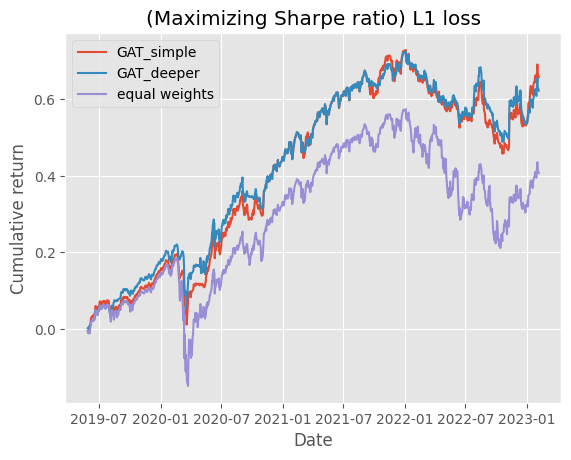

In [59]:
plt.plot(test_return.index, ((test_return.values * weights_matrix_test).sum(axis=1)+1).cumprod()-1, label='GAT_simple')
plt.plot(test_return.index, ((test_return.values * weights_matrix_test_2).sum(axis=1)+1).cumprod()-1, label='GAT_deeper')
plt.plot(((test_return/len(stocks)).sum(axis=1)+1).cumprod()-1, label='equal weights')
plt.xlabel('Date')
plt.ylabel('Cumulative return')
plt.title('(Maximizing Sharpe ratio) L1 loss')
plt.legend()
plt.show()

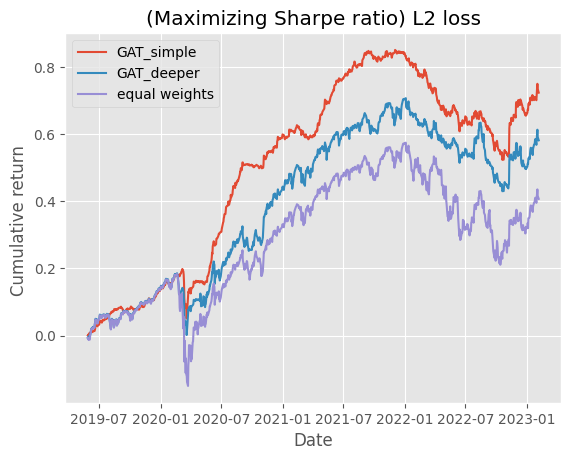

In [60]:
plt.plot(test_return.index, ((test_return.values * weights_matrix_test_l2).sum(axis=1)+1).cumprod()-1, label='GAT_simple')
plt.plot(test_return.index, ((test_return.values * weights_matrix_test_l2_2).sum(axis=1)+1).cumprod()-1, label='GAT_deeper')
plt.plot(((test_return/len(stocks)).sum(axis=1)+1).cumprod()-1, label='equal weights')
plt.xlabel('Date')
plt.ylabel('Cumulative return ')
plt.title('(Maximizing Sharpe ratio) L2 loss')
plt.legend()
plt.show()

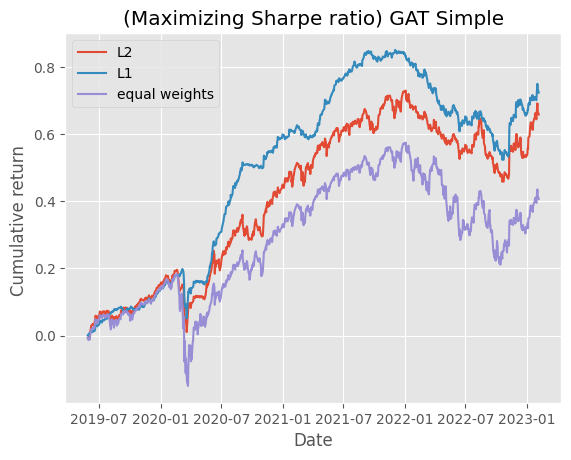

In [61]:
plt.plot(test_return.index, ((test_return.values * weights_matrix_test).sum(axis=1)+1).cumprod()-1, label='L2')
plt.plot(test_return.index, ((test_return.values * weights_matrix_test_l2).sum(axis=1)+1).cumprod()-1, label='L1')
plt.plot(((test_return/len(stocks)).sum(axis=1)+1).cumprod()-1, label='equal weights')
plt.xlabel('Date')
plt.ylabel('Cumulative return ')
plt.title('(Maximizing Sharpe ratio) GAT Simple')
plt.legend()
plt.show()

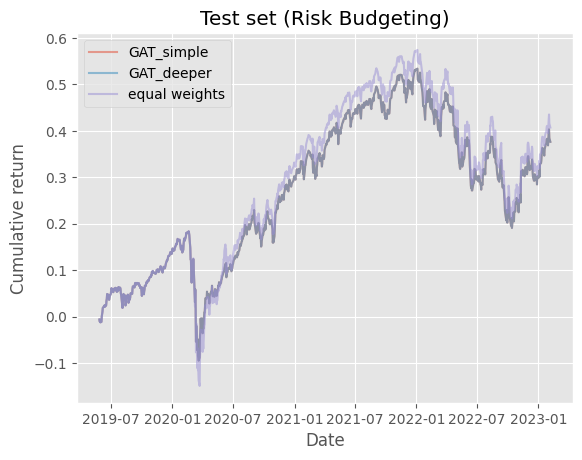

In [62]:
plt.plot(test_return.index, ((test_return.values * weights_matrix_test_budgeting ).sum(axis=1)+1).cumprod()-1, label='GAT_simple', alpha=0.5)
plt.plot(test_return.index, ((test_return.values * weights_matrix_test_budgeting_2).sum(axis=1)+1).cumprod()-1, label='GAT_deeper', alpha=0.5)
plt.plot(((test_return/len(stocks)).sum(axis=1)+1).cumprod()-1, label='equal weights', alpha=0.5)
plt.xlabel('Date')
plt.ylabel('Cumulative return')
plt.title('Test set (Risk Budgeting)')
plt.legend()
plt.show()

In [63]:
sum(weights_matrix_test_budgeting == weights_matrix_test_budgeting_2)/ len(weights_matrix_test_budgeting)

array([0.96030043, 0.95815451, 0.96781116, 0.95922747, 0.96244635,
       0.96459227, 0.96566524, 0.96351931, 0.95922747, 0.96459227])

Notable to say that both (Risk-budgeting) models produced extremely similar results.

### With Smoothing

In [64]:
SMOOTHING_1 = 30

In [65]:
weights_sm_30 = moving_average_2d(weights_matrix_test, SMOOTHING_1)
weights_sm_30_2 = moving_average_2d(weights_matrix_test_2, SMOOTHING_1)

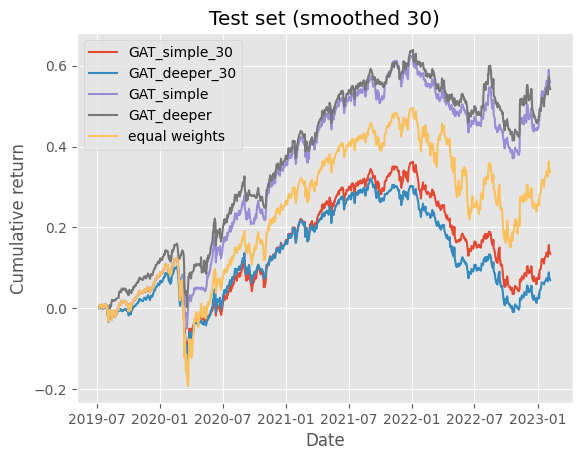

In [66]:
plt.plot(
    test_return.index[SMOOTHING_1-1:],
    ((test_return.values[SMOOTHING_1-1:] * weights_sm_30).sum(axis=1) + 1).cumprod() - 1,
    label="GAT_simple_30",
)
plt.plot(
    test_return.index[SMOOTHING_1-1:],
    ((test_return.values[SMOOTHING_1-1:] * weights_sm_30_2).sum(axis=1) + 1).cumprod() - 1,
    label="GAT_deeper_30",
)

plt.plot(
    test_return.index[SMOOTHING_1-1:],
    ((test_return.values[SMOOTHING_1-1:] * weights_matrix_test[SMOOTHING_1-1:]).sum(axis=1) + 1).cumprod() - 1,
    label="GAT_simple",
)

plt.plot(
    test_return.index[SMOOTHING_1-1:],
    ((test_return.values[SMOOTHING_1-1:] * weights_matrix_test_2[SMOOTHING_1-1:]).sum(axis=1) + 1).cumprod() - 1,
    label="GAT_deeper",
)

plt.plot(
    ((test_return.iloc[SMOOTHING_1-1:] / len(stocks)).sum(axis=1) + 1).cumprod() - 1, label="equal weights"
)

plt.xlabel("Date")
plt.ylabel("Cumulative return")
plt.title(f"Test set (smoothed {SMOOTHING_1})")
plt.legend()
plt.show()


#### Weights dynamics with smoothing

Simple model

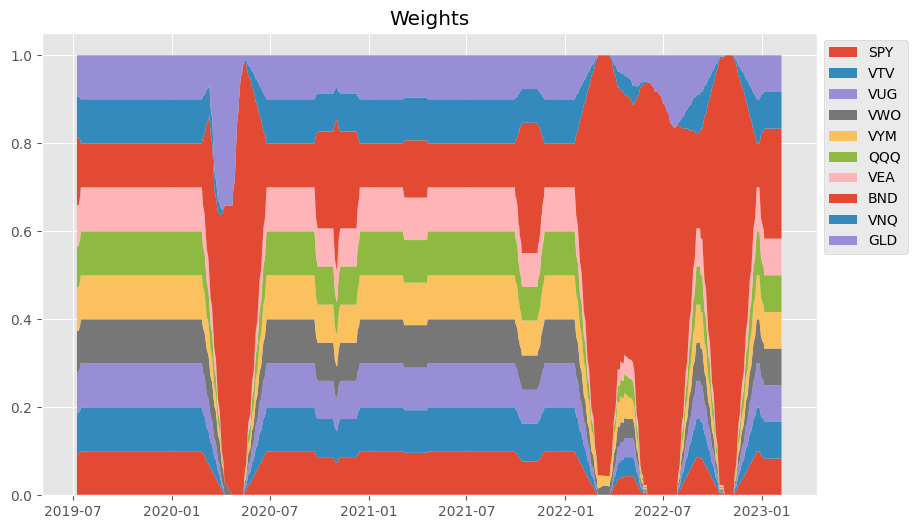

In [67]:
#create area plot for weights legends outside
plt.figure(figsize=(10, 6))
plt.stackplot(test_return.index[SMOOTHING_1-1:], weights_sm_30.T, labels=stocks)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.title('Weights')
plt.show()

When optimizer is able to optimize, we see a clear dominancce of BND ticket

In [68]:
#create table with average weights
pd.DataFrame(weights_sm_30.mean(axis=0), index=stocks, columns=['Average weight']).sort_values(by='Average weight', ascending=False).style.background_gradient(cmap='Blues')

,Average weight
BND,0.315542
GLD,0.092771
VWO,0.075245
VYM,0.075192
VTV,0.073816
VEA,0.073493
SPY,0.073485
QQQ,0.073485
VUG,0.073485
VNQ,0.073485


Deeper model

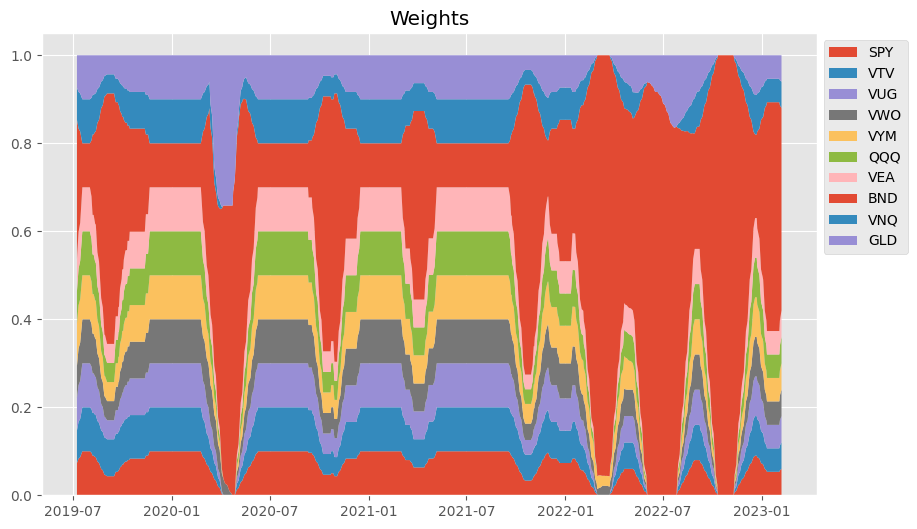

In [69]:
plt.figure(figsize=(10, 6))
plt.stackplot(test_return.index[SMOOTHING_1-1:], weights_sm_30_2.T, labels=stocks)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.title('Weights')
plt.show()

In [70]:
pd.DataFrame(weights_sm_30.mean(axis=0), index=stocks, columns=['Average weight']).sort_values(by='Average weight', ascending=False).style.background_gradient(cmap='Blues')

,Average weight
BND,0.315542
GLD,0.092771
VWO,0.075245
VYM,0.075192
VTV,0.073816
VEA,0.073493
SPY,0.073485
QQQ,0.073485
VUG,0.073485
VNQ,0.073485


Again since most of the times the Sharpe Ratio optimizer wasn't able to optimize we see equal weights.

### Risk Budgeting
#### Simple Model

In [71]:
weights_sm_budget_30 = moving_average_2d(weights_matrix_test_budgeting, SMOOTHING_1)
weights_sm_budget_30_2 = moving_average_2d(weights_matrix_test_budgeting_2, SMOOTHING_1)

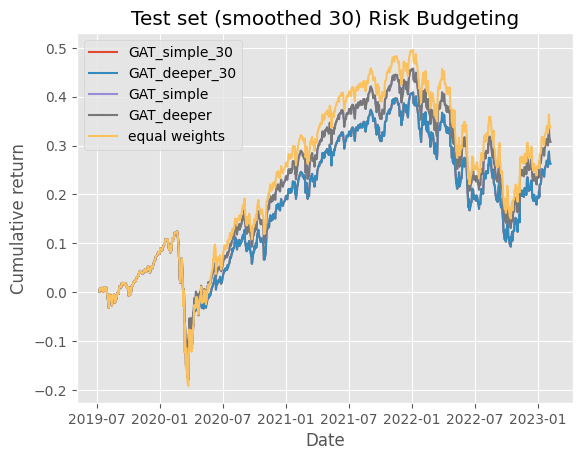

In [72]:
plt.plot(
    test_return.index[SMOOTHING_1-1:],
    ((test_return.values[SMOOTHING_1-1:] * weights_sm_budget_30).sum(axis=1) + 1).cumprod() - 1,
    label="GAT_simple_30",
)
plt.plot(
    test_return.index[SMOOTHING_1-1:],
    ((test_return.values[SMOOTHING_1-1:] * weights_sm_budget_30_2).sum(axis=1) + 1).cumprod() - 1,
    label="GAT_deeper_30",
)

plt.plot(
    test_return.index[SMOOTHING_1-1:],
    ((test_return.values[SMOOTHING_1-1:] * weights_matrix_test_budgeting[SMOOTHING_1-1:]).sum(axis=1) + 1).cumprod() - 1,
    label="GAT_simple",
)

plt.plot(
    test_return.index[SMOOTHING_1-1:],
    ((test_return.values[SMOOTHING_1-1:] * weights_matrix_test_budgeting_2[SMOOTHING_1-1:]).sum(axis=1) + 1).cumprod() - 1,
    label="GAT_deeper",
)

plt.plot(
    ((test_return.iloc[SMOOTHING_1-1:] / len(stocks)).sum(axis=1) + 1).cumprod() - 1, label="equal weights"
)

plt.xlabel("Date")
plt.ylabel("Cumulative return")
plt.title(f"Test set (smoothed {SMOOTHING_1}) Risk Budgeting")
plt.legend()
plt.show()


### Weights dynamics
#### Simple Model

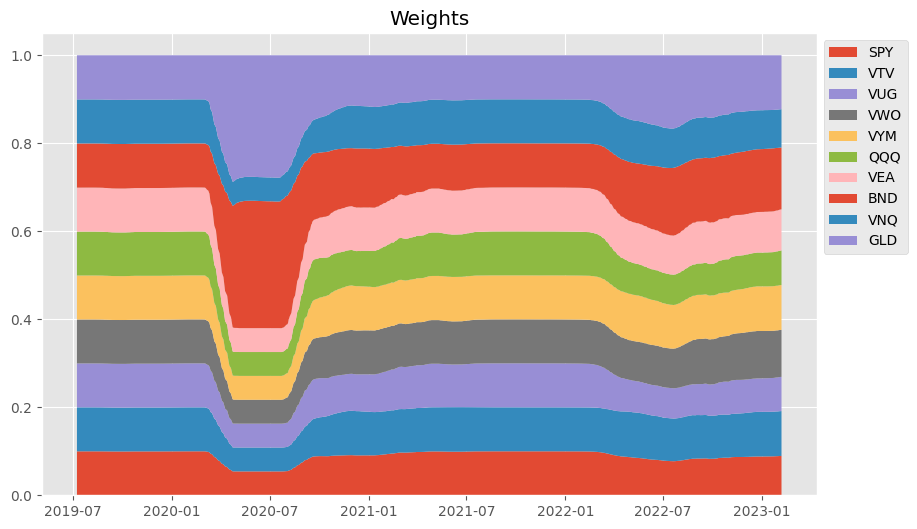

In [73]:
plt.figure(figsize=(10, 6))
plt.stackplot(test_return.index[SMOOTHING_1-1:], weights_sm_budget_30.T, labels=stocks)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.title('Weights')
plt.show()

#### Deep Model

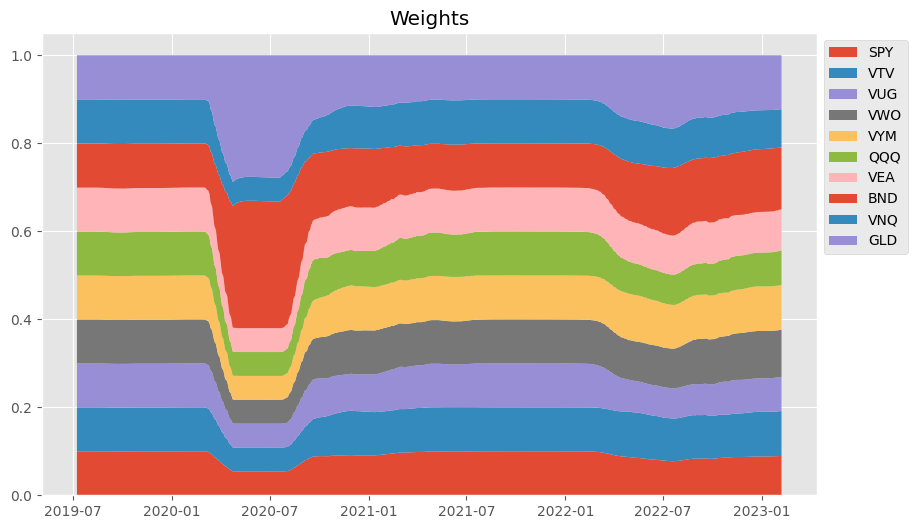

In [74]:
plt.figure(figsize=(10, 6))
plt.stackplot(test_return.index[SMOOTHING_1-1:], weights_sm_budget_30_2.T, labels=stocks)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.title('Weights')
plt.show()

## Furter Steps <a class="anchor" id="steps"></a>

**Conclusions:**

- Deeper models don't quarantee stability. Currentlly, I was unable to make it stable, therefore this is an area for future research.

- But even if optimization works one in three time periods, it is still able to outperform equal-weight portfolio, meaning that optimization goes in the right direction.

- Approximate optimization using risk-budgeting approach didn't bring frutful results.

- Neural networks give a clear advantage to Bonds ETF, since thy have a far lower volatility. It is for a future work, to implement caps on stocks' weights.

**Further steps:**

- It is clear that rebalancing tasks includes additional costs which were not taken into accounty here.

- In this work I optimized only prediction of returns, in future work I will try to combine optimization of weights through backpropagation as well.

- More features should be taken into account, not only technical indicators. 

- There is a great work ahead optimizing a plenum of hyperparameters including loss functions, different layers structures, number of layers, windows to calculate statistics, adjacency matrix weights etc.

- I was unable to compare graph neural networks to other types of neural networks, therefore this is an additional area of research.
